In [1]:
from wobbles.workflow.compute_distribution_function import compute_df
from wobbles.workflow.integrate_single_orbit import integrate_orbit
from wobbles.potential_extension import PotentialExtension
from wobbles.disc import Disc

import numpy as np

import galpy
from galpy.potential import NFWPotential
from galpy.potential import MiyamotoNagaiPotential
from galpy.potential import PowerSphericalPotentialwCutoff
from galpy.potential import IsothermalDiskPotential
from galpy.util.bovy_conversion import dens_in_msolpc3

import astropy.units as apu
import matplotlib.pyplot as plt
import pickle

/Users/danielgilman/Code/external/galpy/galpy/util/bovy_conversion.py:6: FutureWarning: galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9
  warnings.warn('galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9',FutureWarning)

/Users/danielgilman/Code/external/galpy/galpy/util/bovy_plot.py:5: FutureWarning: galpy.util.bovy_plot is being deprecated in favor of galpy.util.plot; functions inside of this module have also changed name, but all functions still exist; please switch to the new import and new function names, because the old import and function names will be removed in v1.9
  warnings.warn('galpy.util.bovy_plot is being deprecated in favor of galpy.util.plot; functions inside of this module 

## Set up the orbit for the satellite

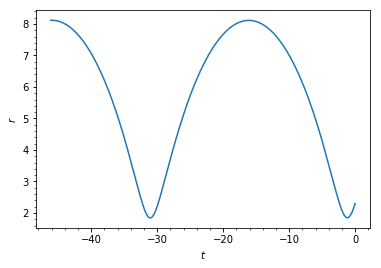

In [3]:
compute_from_scratch = False
if compute_from_scratch:
    z_min_max_kpc = 2.
    vz_min_max_kmsec = 120
    phase_space_N = 100
    # Same as MilkyWayPotential14
    galactic_potential = [PowerSphericalPotentialwCutoff(normalize=0.05,alpha=1.8,
                                                 rc=1.9/8.),
                      MiyamotoNagaiPotential(a=3./8.,b=0.28/8.,normalize=0.6),
                      NFWPotential(a=2.,normalize=0.35)]
    potential_local = PotentialExtension(galactic_potential, z_min_max_kpc, vz_min_max_kmsec, phase_space_N)
    
else:
    f = open('MW14pot_100', "rb")
    potential_extension = pickle.load(f)
    galactic_potential = potential_extension.galactic_potential
    f.close()
    
t_orbit = -1.64 # Gyr
N_tsteps = 1500
time_Gyr = np.linspace(0., t_orbit, N_tsteps) * apu.Gyr 

orbit_init = [283. * apu.deg, -30. * apu.deg, 26. * apu.kpc,
        -2.6 * apu.mas/apu.yr, -1.3 * apu.mas/apu.yr, 140. * apu.km/apu.s] # Initial conditions of the satellite
satellite_orbit_physical_off = integrate_orbit(orbit_init, galactic_potential, time_Gyr)
satellite_orbit_physical_off.plot(d2='r')
satellite_orbit_list = [satellite_orbit_physical_off]

## Set up the perturbing satellite potential, and compute the perturbed distribution functions

In [9]:
satellite_potential_1 = galpy.potential.HernquistPotential(amp=2.*1e10*apu.M_sun,a= 3.*apu.kpc) 
satellite_potential_2 = galpy.potential.HernquistPotential(amp=2.*0.2e9*apu.M_sun,a=0.65*apu.kpc) 
satellite_potential = satellite_potential_1 + satellite_potential_2
satellite_potential_list = [satellite_potential]
galpy.potential.turn_physical_off(satellite_potential)

dF_list = []
delta_J_list = []
force_list = []

velocity_dispersion = [20.5]
normalization = [1.]
time_internal_units = satellite_orbit_list[0].time()
disc = Disc(potential_extension)

dF, delta_J, force = compute_df(disc, time_internal_units,
                          satellite_orbit_list, satellite_potential_list, velocity_dispersion, normalization, 
                                                     verbose=False)

2 1


## Plot results

Text(0,0.5,'$\\rho \\ \\left[M_{\\odot} \\rm{pc^{-2}}\\right]$')

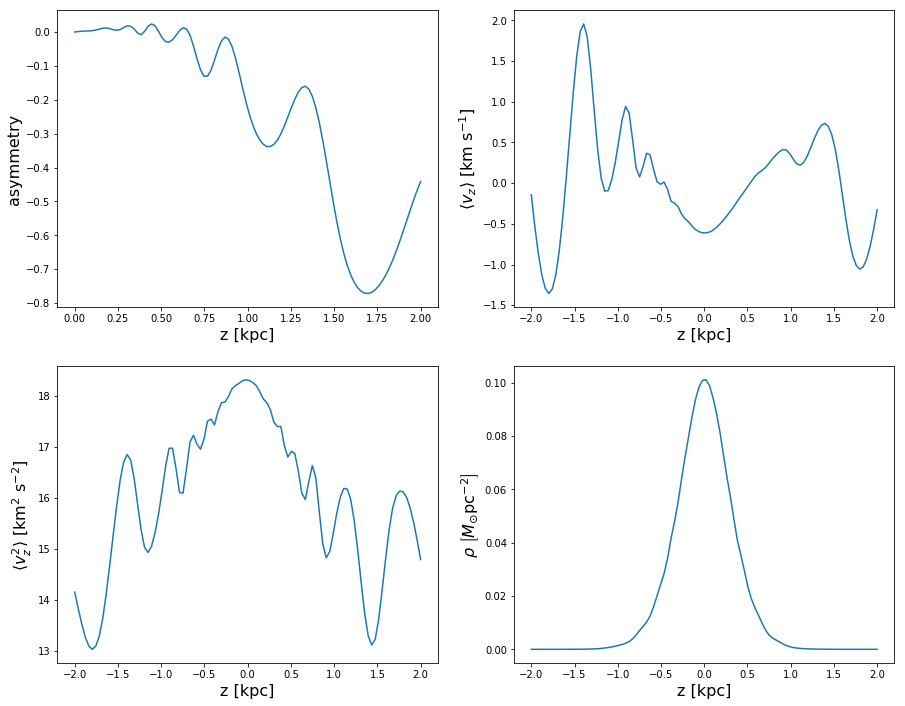

In [30]:
fig = plt.figure(1)
fig.set_size_inches(15, 12)
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

_z = np.linspace(0, 2, len(dF.A))
ax1.plot(_z, dF.A)
ax1.set_xlabel('z [kpc]', fontsize=16)
ax1.set_ylabel('asymmetry', fontsize=16)

_z = np.linspace(-2, 2, len(dF.mean_v_relative))
ax2.plot(_z, dF.mean_v_relative)
ax2.set_xlabel('z [kpc]', fontsize=16)
ax2.set_ylabel(r'$\langle v_z \rangle \ \left[\rm{km \ s^{-1}}\right]$', fontsize=16)

_z = np.linspace(-2, 2, len(dF.velocity_dispersion))
ax3.plot(_z, dF.velocity_dispersion)
ax3.set_xlabel('z [kpc]', fontsize=16)
ax3.set_ylabel(r'$\langle v_z^2 \rangle \ \left[\rm{km^2 \ s^{-2}}\right]$', fontsize=16)

_z = np.linspace(-2, 2, len(dF.velocity_dispersion))
ax4.plot(_z, dF.density)
ax4.set_xlabel('z [kpc]', fontsize=16)
ax4.set_ylabel(r'$\rho \ \left[M_{\odot} \rm{pc^{-2}}\right]$', fontsize=16)